C:\Users\deepa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6868 - loss: 27.2389 - val_accuracy: 0.9910 - val_loss: 0.1733
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9895 - loss: 0.1688 - val_accuracy: 1.0000 - val_loss: 1.2865e-06
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9994 - loss: 0.0325 - val_accuracy: 0.9990 - val_loss: 0.0489
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9979 - loss: 0.0530 - val_accuracy: 0.9980 - val_loss: 0.1484
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 1.0000 - loss: 9.6517e-06 - val_accuracy: 0.9980 - val_loss: 0.1465
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 1.0000 - loss: 7.5823e-11 - val_accuracy: 0.9980 - val_loss: 0.1451
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 2.2460e-11 - val_accuracy: 0.9980 - val_loss: 0.1451
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 1.0823e-10 - val_accura

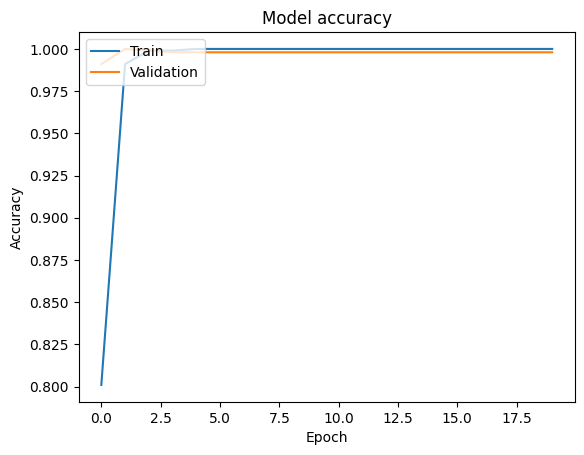

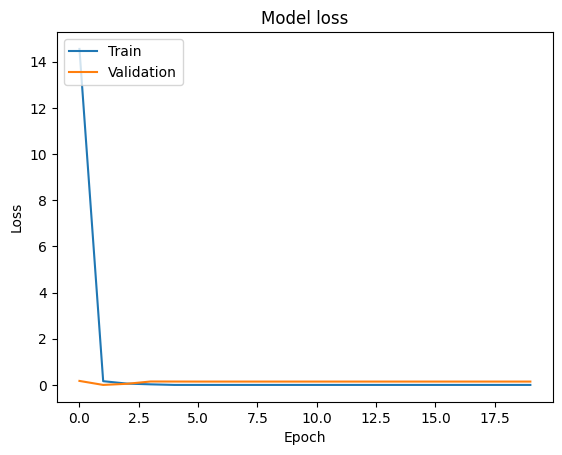

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step
Test Accuracy: 0.500576
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step
Test Accuracy: 0.500576
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       482
           1       1.00      1.00      1.00       518

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Confusion Matrix:
[[482   0]
 [  2 516]]


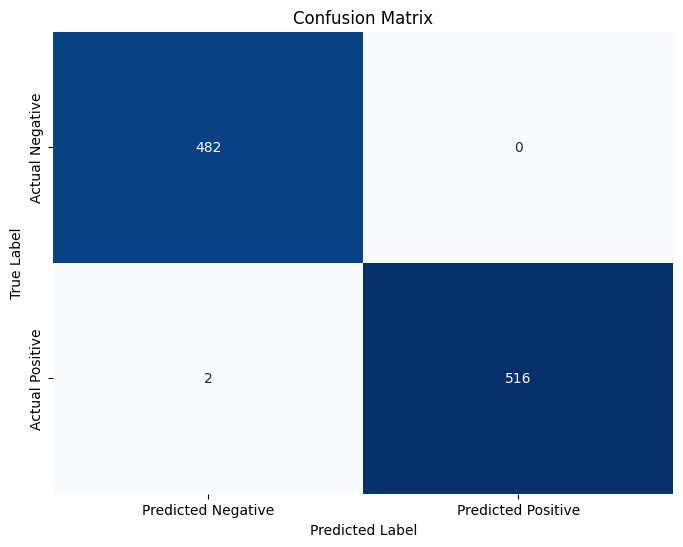

Total Execution Time: 974.60 seconds


In [2]:
import cv2
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

def preprocess_image(image_path, desired_size=(224, 224)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Could not read image: {image_path}")
        return None
    image = cv2.equalizeHist(image)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    h, w = image.shape[:2]
    if w > h:
        new_w, new_h = desired_size[0], h * desired_size[0] // w
    else:
        new_h, new_w = desired_size[1], w * desired_size[1] // h
    image = cv2.resize(image, (new_w, new_h))
    pad_vert = (desired_size[1] - image.shape[0]) // 2
    pad_horz = (desired_size[0] - image.shape[1]) // 2
    image = cv2.copyMakeBorder(image, pad_vert, pad_vert, pad_horz, pad_horz, cv2.BORDER_CONSTANT, value=0)

    # Add channel dimension
    image = np.expand_dims(image, axis=-1)

    return image

def load_data(contact_dir, contactless_dir, test_size=0.2):
    images_contact = []
    images_contactless = []

    for filename in glob(os.path.join(contact_dir, '*.jpg')):
        img = preprocess_image(filename)
        if img is not None:
            images_contact.append(img)

    for filename in glob(os.path.join(contactless_dir, '*.bmp')):
        img = preprocess_image(filename)
        if img is not None:
            images_contactless.append(img)

    X_contact = np.array(images_contact)
    X_contactless = np.array(images_contactless)
    y_contact = np.zeros(X_contact.shape[0])
    y_contactless = np.ones(X_contactless.shape[0])

    X = np.concatenate([X_contact, X_contactless], axis=0)
    y = np.concatenate([y_contact, y_contactless], axis=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

def generate_pairs(X, y, num_pairs=1000):
    pairs = []
    labels = []

    for _ in range(num_pairs):
        idx1, idx2 = np.random.choice(X.shape[0], size=2, replace=False)
        image1, image2 = X[idx1], X[idx2]
        pairs.append([image1, image2])
        labels.append(1 if y[idx1] == y[idx2] else 0)

    return np.array(pairs), np.array(labels)

def siamese_model(input_shape):
    input_left = Input(shape=input_shape)
    input_right = Input(shape=input_shape)

    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
    ])

    output_left = model(input_left)
    output_right = model(input_right)

    distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([output_left, output_right])
    output = Dense(1, activation='sigmoid')(distance)

    model = Model(inputs=[input_left, input_right], outputs=output)
    return model

def plot_training_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, X_test_pairs, y_test_pairs):
    y_pred = model.predict([X_test_pairs[:, 0], X_test_pairs[:, 1]])
    y_pred_binary = np.round(y_pred)

    accuracy = np.mean(y_pred_binary == y_test_pairs)
    print("Test Accuracy:", accuracy)

    print("Classification Report:")
    print(classification_report(y_test_pairs, y_pred_binary))

    conf_matrix = confusion_matrix(y_test_pairs, y_pred_binary)
    print("Confusion Matrix:")
    print(conf_matrix)
    plot_confusion_matrix(conf_matrix)

def main():
    start_time = time.time()

    contact_dir = 'Database/Contact_images'
    contactless_dir = 'Database/Contactless_images'

    X_train, X_test, y_train, y_test = load_data(contact_dir, contactless_dir)

    X_train_pairs, y_train_pairs = generate_pairs(X_train, y_train)
    X_test_pairs, y_test_pairs = generate_pairs(X_test, y_test)

    input_shape = X_train[0].shape
    model = siamese_model(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit([X_train_pairs[:, 0], X_train_pairs[:, 1]], y_train_pairs, epochs=20, batch_size=32, validation_data=([X_test_pairs[:, 0], X_test_pairs[:, 1]], y_test_pairs))

    plot_training_history(history)

    y_pred = model.predict([X_test_pairs[:, 0], X_test_pairs[:, 1]])
    y_pred_binary = np.round(y_pred)

    accuracy = np.mean(y_pred_binary == y_test_pairs)
    print("Test Accuracy:", accuracy)

    evaluate_model(model, X_test_pairs, y_test_pairs)

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total Execution Time: {total_time:.2f} seconds")

if __name__ == "__main__":
    main()
